In [12]:
import os
import shutil
import chess
import chess.pgn
import torch
import torch.nn as nn
from stockfish import Stockfish
from IPython.display import SVG, display

import mcts 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
KAGGLE = False

if KAGGLE:
    input_stockfish_path = "/kaggle/input/stockfish_ubuntu/other/default/1/stockfish-ubuntu-x86-64-avx2"
    stockfish_path = "/kaggle/working/stockfish"
    if not os.path.exists(stockfish_path):
        shutil.copy(input_stockfish_path, stockfish_path)
    os.chmod(stockfish_path, 0o755)
else:
    stockfish_path = "../models/validation_stockfish/stockfish-windows-x86-64-avx2.exe"

stockfish = Stockfish(path=stockfish_path)
stockfish.set_skill_level(8)


In [14]:
class ConvBlock(nn.Module):
    def __init__(self, input_channels, num_filters):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels= input_channels, out_channels=num_filters, kernel_size = 3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=num_filters)
        self.relu1 = nn.ReLU()

    def __call__(self, x):
        return self.relu1(self.bn1(self.conv1(x)))

In [15]:
class ResidualBlock(nn.Module):
    def __init__(self, num_filters):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=num_filters, out_channels=num_filters, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features = num_filters)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=num_filters, out_channels=num_filters, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(num_features=num_filters)
        self.relu2 = nn.ReLU()

    def __call__(self, x):
        residual = x
        temp = self.relu1(self.bn1(self.conv1(x)))
        output = self.relu2(self.bn2(self.conv2(temp)) + residual)
        return output


In [16]:
class ValueHead(nn.Module):
    def __init__(self, input_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=input_channels, out_channels=1, kernel_size=1)
        self.bn1 = nn.BatchNorm2d(num_features=1)
        self.relu1 = nn.ReLU()
        self.fc1 = nn.Linear(64, 256)
        self.relu2 = nn.ReLU()
        self.fc2 = nn.Linear(256, 1)
        self.tanh1 = nn.Tanh()

    def __call__(self, x):
        temp1 = self.relu1(self.bn1(self.conv1(x)))
        view = temp1.view(temp1.shape[0], 64)
        temp2 = self.tanh1(self.fc2(self.relu2(self.fc1(view))))
        return temp2


In [17]:
class PolicyHead(nn.Module):
    def __init__(self, input_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=input_channels, out_channels=2, kernel_size=1)
        self.bn1 = nn.BatchNorm2d(num_features=2)
        self.relu1 = nn.ReLU()
        self.fc1 = nn.Linear(128, 4608)

    def __call__(self, x):
        temp = self.relu1(self.bn1(self.conv1(x)))
        view = temp.view(temp.shape[0], 128)
        temp = self.fc1(view)
        return temp

In [18]:
class AlphaZero(nn.Module):
    def __init__(self, num_blocks, num_filters):
        super().__init__()
        self.convBlock1 = ConvBlock(16, num_filters)
        residual_blocks = []
        for i in range(num_blocks):
            residual_blocks.append(ResidualBlock(num_filters))
        self.residualBlocks = nn.ModuleList(residual_blocks)            
        self.valueHead = ValueHead(num_filters)            
        self.policyHead = PolicyHead(num_filters)            
        self.softmax1 = nn.Softmax(dim=1)            
        self.mseLoss = nn.MSELoss()            
        self.crossEntropyLoss = nn.CrossEntropyLoss()
        

    def __call__(self, x, value_target=None, policy_target=None, policy_mask=None):
        x = self.convBlock1(x)
        for block in self.residualBlocks:
            x = block(x)
        value,policy = self.valueHead(x),self.policyHead(x)
        
        if self.training:
            value_loss = self.mseLoss(value, value_target)
            policy_target = policy_target.view(policy_target.shape[0])
            policy_loss = self.cross_entropy_loss(policy, policy_target)
            return value_loss, policy_loss
        else:
            policy_mask = policy_mask.view(policy_mask.shape[0], -1)
            policy_exp = torch.exp(policy)
            policy_exp *= policy_mask.type(torch.float32)
            policy_exp_sum = torch.sum(policy_exp, dim=1, keepdim=True)
            policy_softmax = policy_exp / policy_exp_sum
            return value, policy_softmax


In [21]:
model_path = "alpha_zero_net"
color = False # Black
rollouts = 10
threads = 10

def display_board(board):
    """Displays the current state of the board."""
    svg_board = chess.svg.board(board=board)
    display(SVG(svg_board))


def main(model_file, color, num_rollouts, num_threads, stockfish):
    az = AlphaZero(20, 256)
    if device == 'cuda':
        weights = torch.load(model_file)
        az.load_state_dict(weights)
        az = az.device()
    else:
        weights = torch.load(model_file, map_location=torch.device('cpu'))
        az.load_state_dict(weights)
    for param in az.parameters():
        param.requires_grad = False
    az.eval()

    board = chess.Board()
    
    if color == chess.WHITE:
        print("Alpha zero - white")
    else:
        print("Alpha zero - black")


    while True:
        print(board)
        print()
        
        if board.is_game_over():
            print('Game over. Winner: {}'.format(board.result()))
            display_board(board)
            break

        if board.turn == color:
            print("stockfish")
            stockfish.set_fen_position(board.fen())
            chosen_move = chess.Move.from_uci(stockfish.get_best_move())
            board.push(chosen_move)
        else:
            print('alpha')
            
            with torch.no_grad():
                root = mcts.Root(board, az)
                for i in range(num_rollouts):
                    root.parallel_rollouts(board.copy(), az, num_threads)

            edge = root.select_max_n()
            best_move = edge.get_move()
            board.push(best_move)

Alpha zero - black
r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
P P P P P P P P
R N B Q K B N R

alpha
r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . P . . . .
. . . . . . . .
P P P . P P P P
R N B Q K B N R

stockfish
r n b q k b n r
p p p p . p p p
. . . . p . . .
. . . . . . . .
. . . P . . . .
. . . . . . . .
P P P . P P P P
R N B Q K B N R

alpha
r n b q k b n r
p p p p . p p p
. . . . p . . .
. . . . . . . .
. . . P P . . .
. . . . . . . .
P P P . . P P P
R N B Q K B N R

stockfish
r n b q k b n r
. p p p . p p p
p . . . p . . .
. . . . . . . .
. . . P P . . .
. . . . . . . .
P P P . . P P P
R N B Q K B N R

alpha
r n b q k b n r
. p p p . p p p
p . . . p . . .
. . . . . . . .
. . . P P . . .
. . . . . N . .
P P P . . P P P
R N B Q K B . R

stockfish
r n b q k b n r
. p . p . p p p
p . . . p . . .
. . p . . . . .
. . . P P . . .
. . . . . N . .
P P P . . P P P
R N B Q K B . R

alpha
r n b q k b n r
. p . p 

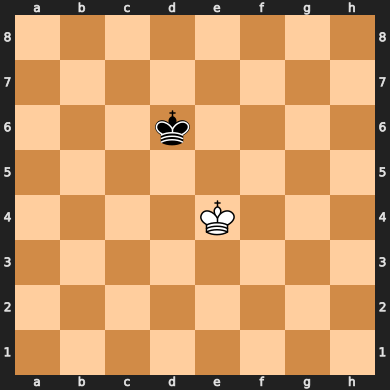

In [23]:
main(model_path, color, rollouts, threads, stockfish)